In [1]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import numpy as np
import os

In [2]:
watershed_lvl_fp = os.path.relpath("../datasets/reservoirs/reservoir_lvls.csv")

In [29]:
lvls_df = pd.read_csv(watershed_lvl_fp)

In [30]:
pd.to_datetime(lvls_df.Point_time.unique()).sort_values(ascending=True)
lvls_df['date'] = pd.to_datetime(lvls_df.Point_time)

In [31]:
lvls_df['date'].value_counts()

date
2021-03-02    2
2021-03-01    2
2024-05-01    2
2024-05-02    2
2024-05-03    2
             ..
2019-02-12    1
2019-02-13    1
2019-02-14    1
2019-02-15    1
2019-02-16    1
Name: count, Length: 2544, dtype: int64

In [ ]:
# double_date = np.datetime64("2021-03-02")
# lvls_df[lvls_df['date'] == double_date]

,Point_time,AUGEVolume,AUGEASTLEVANALOG,AUGWVOLUME,AUGWESTLEVANALOG,ASHREL,SICRESVOLUME,SICRESELEVANALOG,STPALBFLW,RECRESVOLUME,...,NICCONFLW,EDIRESVOLUME,EDIRESELEVANALOG,EDRNTHFLW,EDRSTHFLW,EDRCONFLW,WDIRESVOLUME,WDIRESELEVANALOG,WDRFLW,date
1216,03/02/2021,66.32,579.78,43.82,588.34,8.0,15.03,1120.44,0.0,47.57,...,0.0,117.71,1265.69,0.0,65.0,0.0,77.24,1138.12,112.3,2021-03-02
1218,03/02/2021,66.32,579.78,43.82,588.34,8.0,15.03,1120.44,0.0,47.57,...,0.0,117.71,1265.69,0.0,65.0,0.0,77.24,1138.12,112.3,2021-03-02


In [32]:
lvls_df = lvls_df.drop_duplicates()

In [33]:
lvls_by_date_df = lvls_df.set_index("date").sort_index(ascending=True).sort_index()

In [ ]:
lvls_by_date_df
# Ashokan 11/3/2017 = 101.54 billion gallons, rel: 12 million gallons per day
# Ashokan 11/2/2017 = 101.77 billion gallons, rel: 11 million gallons per day
# Ashokan 11/1/2017 = 101.7

,Point_time,AUGEVolume,AUGEASTLEVANALOG,AUGWVOLUME,AUGWESTLEVANALOG,ASHREL,SICRESVOLUME,SICRESELEVANALOG,STPALBFLW,RECRESVOLUME,...,NICSTHFLW,NICCONFLW,EDIRESVOLUME,EDIRESELEVANALOG,EDRNTHFLW,EDRSTHFLW,EDRCONFLW,WDIRESVOLUME,WDIRESELEVANALOG,WDRFLW
date,,,,,,,,,,,,,,,,,,,,,
2017-11-01,11/01/2017,65.360000,577.860000,36.340000,577.890000,18.0,12.92,1109.86,0.0,47.260000,...,0.000000,0.0,116.60,1264.450000,51.70,0.0,0.0,47.69,1112.87,97.30
2017-11-02,11/02/2017,64.950000,577.580000,36.820000,578.590000,11.0,13.28,1111.05,0.0,47.320000,...,0.000000,0.0,116.87,1264.610000,51.70,0.0,0.0,48.20,1113.33,97.60
2017-11-03,11/03/2017,64.360000,577.310000,37.180000,579.140000,12.0,13.56,1111.97,0.0,47.220000,...,0.000000,0.0,117.08,1264.740000,51.80,0.0,0.0,48.66,1113.74,97.80
2017-11-04,11/04/2017,63.710000,576.940000,37.490000,579.560000,12.0,13.78,1112.73,0.0,47.280000,...,0.000000,0.0,117.15,1264.780000,51.80,0.0,0.0,49.05,1114.09,98.00
2017-11-05,11/05/2017,63.150000,576.520000,37.780000,579.920000,12.0,13.98,1113.39,0.0,47.360000,...,0.000000,0.0,117.11,1264.760000,51.80,0.0,0.0,49.35,1114.36,97.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,12/27/2024,57.210396,573.234375,33.815323,577.837646,NaN,8.00,13.64,0.0,460.700012,...,30.300001,0.0,0.00,104.396118,1257.48,0.0,42.3,0.00,60.62,1125.39
2024-12-28,12/28/2024,57.404480,573.352722,33.961895,577.912659,NaN,9.00,13.48,0.0,503.500000,...,30.800001,0.0,0.00,104.288231,1257.41,0.0,43.3,0.00,60.82,1125.55
2024-12-29,12/29/2024,57.742203,573.491272,34.566723,578.061768,NaN,10.00,13.46,0.0,505.000000,...,30.700001,0.0,0.00,104.766144,1257.73,0.0,43.2,0.00,61.45,1126.05


<Axes: xlabel='AUGEVolume', ylabel='Count'>

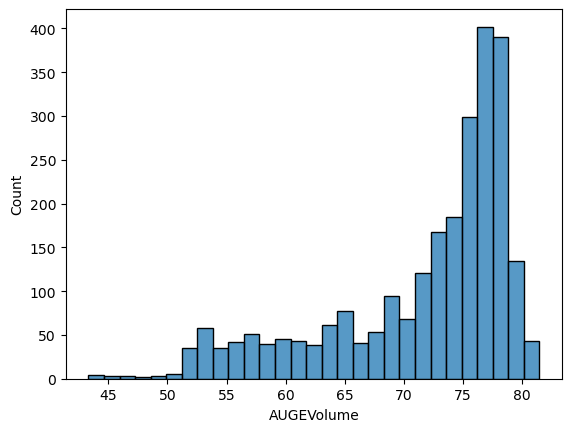

In [27]:
sns.histplot(lvls_df, x=lvls_df.AUGEVolume)

<Axes: xlabel='date', ylabel='AUGEVolume'>

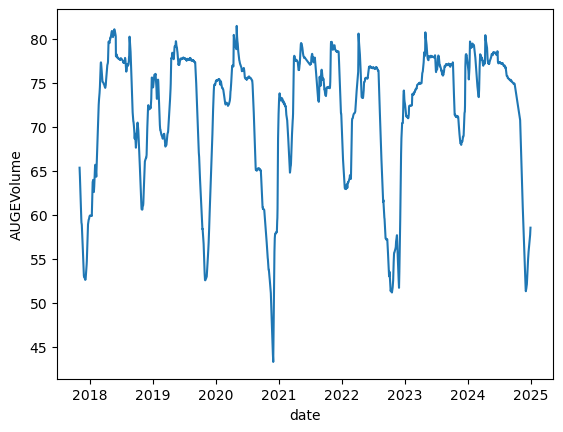

In [40]:
sns.lineplot(lvls_df, x="date", y="AUGEVolume")